# Implementation of MuZero algorithm

## Based on the official DeepMind pseudocode

### Imports

In [1]:
!pip install tensorflow==2.3.0

import collections
import math
import typing
from typing import Dict, List, Optional

import numpy as np
import tensorflow as tf

from tensorflow.keras.regularizers import L2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

tf.keras.backend.set_floatx('float32')
tf.random.set_seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output

import time

import gym

## Helpers

### MinMaxStats

In [2]:
MAXIMUM_FLOAT_VALUE = float('inf')

KnownBounds = collections.namedtuple('KnownBounds', ['min', 'max'])

class MinMaxStats(object):
  
    """A class that holds the min-max values of the tree."""

    def __init__(self, known_bounds: Optional[KnownBounds]):
        
        self.maximum = known_bounds.max if known_bounds else -MAXIMUM_FLOAT_VALUE
        self.minimum = known_bounds.min if known_bounds else MAXIMUM_FLOAT_VALUE

    def update(self, value: float):
        
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value: float) -> float:
        
        if self.maximum > self.minimum:
            # We normalize only when we have set the maximum and minimum values.
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value

### MuZero configs

In [3]:
class MuZeroConfig(object):

    def __init__(self,
                 action_space_size: int,
                 observation_space_size: int,
                 max_moves: int,
                 discount: float,
                 dirichlet_alpha: float,
                 num_simulations: int,
                 batch_size: int,
                 td_steps: int,
                 num_actors: int,
                 lr_init: float,
                 lr_decay_steps: float,
                 training_episodes: int,
                 hidden_layer_size: int,
                 visit_softmax_temperature_fn,
                 known_bounds: Optional[KnownBounds] = None):
        
        ### Self-Play
        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.num_actors = num_actors

        self.visit_softmax_temperature_fn = visit_softmax_temperature_fn
        self.max_moves = max_moves
        self.num_simulations = num_simulations
        self.discount = discount

        # Root prior exploration noise.
        self.root_dirichlet_alpha = dirichlet_alpha
        self.root_exploration_fraction = 0.25

        # UCB formula
        self.pb_c_base = 19652
        self.pb_c_init = 1.25

        # If we already have some information about which values occur in the
        # environment, we can use them to initialize the rescaling.
        # This is not strictly necessary, but establishes identical behaviour to
        # AlphaZero in board games.
        self.known_bounds = known_bounds

        ### Training
        self.training_steps = int(500e3)
        self.checkpoint_interval = int(1e3)
        self.window_size = int(1000)
        self.batch_size = batch_size
        self.num_unroll_steps = 500
        self.td_steps = td_steps

        self.weight_decay = 1e-4
        self.momentum = 0.9
        
        self.training_episodes = training_episodes
        
        self.hidden_layer_size = hidden_layer_size

        # Exponential learning rate schedule
        self.lr_init = lr_init
        self.lr_decay_rate = 0.1
        self.lr_decay_steps = lr_decay_steps

    def new_game(self):
        
        return Game(self.action_space_size, self.discount)
    
    
class CartPoleConfig(MuZeroConfig):

    def new_game(self):
        
        return CartPoleGame(self.action_space_size, self.discount)

### Make CartPole config

In [4]:
def make_cartpole_config() -> MuZeroConfig:

    def visit_softmax_temperature(num_moves, training_steps):
        
        # higher temperature higher exploration
        
        if training_steps < 100:
            return 3
        elif training_steps < 125:
            return 2      
        elif training_steps < 150:
            return 1      
        elif training_steps < 175:
            return 0.5      
        elif training_steps < 200:
            return 0.250      
        elif training_steps < 225:
            return 0.125      
        elif training_steps < 250:
            return 0.075
        else:
            return 0.001
        
    return CartPoleConfig(action_space_size=2,
                          observation_space_size = 4,
                          max_moves=500,
                          discount=0.997,
                          dirichlet_alpha=0.25,
                          num_simulations=150,
                          batch_size=100,
                          td_steps=7,
                          num_actors=1,
                          lr_init=0.0001,
                          lr_decay_steps=5000,
                          training_episodes=225,
                          hidden_layer_size=32,
                          visit_softmax_temperature_fn=visit_softmax_temperature)

### Action

In [5]:
class Action(object):

    def __init__(self, index: int):
        self.index = index

    def __hash__(self):
        return self.index

    def __eq__(self, other):
        return self.index == other.index

    def __gt__(self, other):
        return self.index > other.index
    
    def __str__(self):
        return str(self.index)

### Player

In [6]:
class Player(object):

    def __init__(self, index: int):
        self.index = index

    def __hash__(self):
        return self.index

    def __eq__(self, other):
        return self.index == other.index

    def __gt__(self, other):
        return self.index > other.index
    
    def __str__(self):
        return str(self.index)

### Node

In [7]:
class Node(object):

    def __init__(self, prior: float):
        
        self.visit_count = 0
        self.to_play = -1
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_state = None
        self.reward = 0

    def expanded(self) -> bool:
        
        return len(self.children) > 0

    def value(self) -> float:
        
        if self.visit_count == 0:
            return 0
        else:
            return self.value_sum / self.visit_count

### ActionHistory

In [8]:
class ActionHistory(object):

    """Simple history container used inside the search.
       Only used to keep track of the actions executed.
    """

    def __init__(self, history: List[Action], action_space_size: int):
        
        self.history = list(history)
        self.action_space_size = action_space_size

    def clone(self):
        
        return ActionHistory(self.history, self.action_space_size)

    def add_action(self, action: Action):
        
        self.history.append(action)

    def last_action(self) -> Action:
        
        return self.history[-1]

    def action_space(self) -> List[Action]:
        
        return [Action(i) for i in range(self.action_space_size)]

    def to_play(self) -> Player:
        
        return Player(1)

### Environment

In [9]:
class Environment(object):
  
    """The environment MuZero is interacting with."""

    def step(self, action):
        pass
    
    
class GymEnvironment(Environment):
  
    """The openAI gym environment MuZero is interacting with."""

    def __init__(self):
        
        self.env = None
        
    
    def step(self, action):
        
        return self.environment.step(action)
    
    
class CartPoleEnvironment(GymEnvironment):
  
    """The openAI CartPole gym environment MuZero is interacting with."""

    def __init__(self):
        
        super().__init__()
        self.env = gym.make('CartPole-v1')
        
    
    def step(self, action):
        
        return self.env.step(action)

### Game

In [10]:
class Game(object):
    
    """A single episode of interaction with the environment."""

    def __init__(self, action_space_size: int, discount: float):
        
        self.environment = self.create_environment()  
        self.history = []
        self.rewards = []
        self.child_visits = []
        self.root_values = []
        self.action_space_size = action_space_size
        self.discount = discount
        
    def create_environment(self):
        
        # Game specific environment. 
        pass

    def terminal(self) -> bool:
        
        # Game specific termination rules.
        pass

    def legal_actions(self) -> List[Action]:
        
        # Game specific calculation of legal actions.
        pass

    def apply(self, action: Action):
        
        reward = self.environment.step(action)
        self.rewards.append(reward)
        self.history.append(action)

    def store_search_statistics(self, root: Node):
        
        sum_visits = sum(child.visit_count for child in root.children.values())
        action_space = (Action(index) for index in range(self.action_space_size))
        self.child_visits.append([
            root.children[a].visit_count / sum_visits if a in root.children else 0
            for a in action_space
        ])
        self.root_values.append(root.value())

    def make_image(self, state_index: int):
        
        # Game specific feature planes.
        pass

    def make_target(self, state_index: int, num_unroll_steps: int, td_steps: int, to_play: Player, action_space_size: int):
        
        # The value target is the discounted root value of the search tree N steps
        # into the future, plus the discounted sum of all rewards until then.
        targets = []
        for current_index in range(state_index, state_index + num_unroll_steps + 1):
            bootstrap_index = current_index + td_steps
            if bootstrap_index < len(self.root_values):
                value = self.root_values[bootstrap_index] * self.discount**td_steps
            else:
                value = 0

            for i, reward in enumerate(self.rewards[current_index:bootstrap_index]):
                value += reward * self.discount**i  # pytype: disable=unsupported-operands

            if current_index > 0 and current_index <= len(self.rewards):
                last_reward = self.rewards[current_index - 1]
            else:
                last_reward = None

            if current_index < len(self.root_values):
                targets.append((value, last_reward, self.child_visits[current_index]))
            else:
                # States past the end of games are treated as absorbing states.
                targets.append((0, last_reward, []))
        
        return targets

    def to_play(self) -> Player:
        
        return Player(1)

    def action_history(self) -> ActionHistory:
        
        return ActionHistory(self.history, self.action_space_size)
    
    def total_rewards(self):
        
        return sum(self.rewards)
    
    
class GymGame(Game):
    
    """A single episode of interaction with an openAI gym environment."""

    def __init__(self, action_space_size: int, discount: float):
        
        self.observations = []
        self.done = False
        super().__init__(action_space_size, discount)  

    def terminal(self) -> bool:
        
        # Game specific termination rules.
        return self.done

    def legal_actions(self) -> List[Action]:
        
        # Game specific calculation of legal actions.
        return [Action(index) for index in range(self.action_space_size)]

    def apply(self, action: Action):
        
        observation, reward, done, _ = self.environment.step(action)
        self.rewards.append(reward)
        self.history.append(action)
        self.add_observation(observation)
        self.done = done
        if done:
            self.environment.env.close()
        print('rewards: ' + str(sum(self.rewards)))

    def make_image(self, state_index: int):
        
        # Game specific feature planes.
        return self.observations[state_index]
    
    def add_observation(self, observation):
        
        self.observations.append(observation)       
        
    def create_environment(self):
        
        # Game specific environment.
        game = self.create_gym_environment()
        self.add_observation(game.env.reset())
        return game
    
    def create_gym_environment(self):
        pass
    
    
class CartPoleGame(GymGame):
    
    def __init__(self, action_space_size: int, discount: float):
        
        super().__init__(action_space_size, discount)
    
    def create_gym_environment(self):
        return CartPoleEnvironment()

### ReplayBuffer

In [11]:
class ReplayBuffer(object):

    def __init__(self, config: MuZeroConfig):
        
        self.window_size = config.window_size
        self.batch_size = config.batch_size
        self.buffer = []

    def save_game(self, game):
        
        if len(self.buffer) > self.window_size:
            self.buffer.pop(0)
        self.buffer.append(game)

    def sample_batch(self, num_unroll_steps: int, td_steps: int, action_space_size: int):
        
        games = [self.sample_game() for _ in range(self.batch_size)]
        game_pos = [(g, self.sample_position(g)) for g in games]
        return [(g.make_image(i), 
                 g.history[i:i + num_unroll_steps],
                 g.make_target(i, num_unroll_steps, td_steps, g.to_play(), action_space_size))
                for (g, i) in game_pos]

    def sample_game(self) -> Game:
        
        # Sample game from buffer either uniformly or according to some priority.
        return self.buffer[np.random.choice(range(len(self.buffer)))]

    def sample_position(self, game) -> int:
        
        # Sample position from game either uniformly or according to some priority.
        return np.random.choice(range(len(game.rewards) - 1))
    
    def last_game(self) -> Game:
        
        return self.buffer[-1]

### Network

In [12]:
class NetworkOutput(typing.NamedTuple):
    
    value: float
    reward: float
    policy_logits: Dict[Action, float]
    policy_tensor: List[float]
    hidden_state: List[float]

        
class Network(object):    

    def __init__(self, config):
        
        #regularizer = L2(config.weight_decay)
        
        self.representation = keras.Sequential([Dense(config.hidden_layer_size, activation='relu'),
                                                Dense(config.hidden_layer_size)])
        
        self.value = keras.Sequential([Dense(config.hidden_layer_size, activation='relu'),
                                       Dense(1, activation='relu')])
        
        self.policy = keras.Sequential([Dense(config.hidden_layer_size, activation='relu'),
                                        Dense(config.action_space_size, activation='softmax')])
        
        self.reward = keras.Sequential([Dense(config.hidden_layer_size, activation='relu'),
                                        Dense(1, activation='relu')])
        
        self.dynamics = keras.Sequential([Dense(config.hidden_layer_size, activation='relu'),
                                          Dense(config.hidden_layer_size)])
        
        self.tot_training_steps = 0
        
        self.action_space_size = config.action_space_size
                
        
    def initial_inference(self, image) -> NetworkOutput:
        
        # representation + prediction function
        
        hidden_state = self.representation(np.expand_dims(image, 0))
        
        #hidden_state = tf.keras.utils.normalize(hidden_state)
                        
        value = self.value(hidden_state)
        policy = self.policy(hidden_state)
        reward = tf.constant([[0]], dtype=tf.float32)        
        policy_p = policy[0]
        
        return NetworkOutput(value, 
                             reward, 
                             {Action(a): policy_p[a] for a in range(len(policy_p))},
                             policy,
                             hidden_state)
    
    def recurrent_inference(self, hidden_state, action) -> NetworkOutput:        
        
        # dynamics + prediction function                 
        
        a = hidden_state.numpy()[0]
        b = np.eye(self.action_space_size)[action.index]
        nn_input = np.concatenate((a, b))
        nn_input = np.expand_dims(nn_input, axis=0)
        
        next_hidden_state = self.dynamics(nn_input) 
                
        #next_hidden_state = tf.keras.utils.normalize(next_hidden_state)
        
        reward = self.reward(nn_input)
        value = self.value(next_hidden_state)
        policy = self.policy(next_hidden_state)      
        policy_p = policy[0]
                
        return NetworkOutput(value, 
                             reward, 
                             {Action(a): policy_p[a] for a in range(len(policy_p))},
                             policy,
                             next_hidden_state)

    def get_weights_func(self):
        
        # Returns the weights of this network.

        def get_variables():
            networks = (self.representation, 
                        self.value, 
                        self.policy,
                        self.dynamics, 
                        self.reward)
            return [variables
                    for variables_list in map(lambda n: n.weights, networks)
                    for variables in variables_list]

        return get_variables        

    def get_weights(self):
        
        # Returns the weights of this network.

        networks = (self.representation, 
                        self.value, 
                        self.policy,
                        self.dynamics, 
                        self.reward)
        return [variables
                for variables_list in map(lambda n: n.weights, networks)
                for variables in variables_list]          
            
    def training_steps(self) -> int:
        
        # How many steps / batches the network has been trained for.
        return self.tot_training_steps

### SharedStorage

In [13]:
'''
class SharedStorage(object):

    def __init__(self):
        
        self._networks = {}

    def latest_network(self) -> Network:
        
        if self._networks:
            return self._networks[max(self._networks.keys())]
        else:
            # policy -> uniform, value -> 0, reward -> 0
            return make_uniform_network()

    def save_network(self, step: int, network: Network):
        
        self._networks[step] = network
'''

class SharedStorage(object):

    def __init__(self, config):
        
        self.network = Network(config)

    def latest_network(self) -> Network:
        
        return self.network

    def save_network(self, step: int, network: Network):
        
        pass

## Part 1: Self-Play

In [14]:
# Each self-play job is independent of all others; it takes the latest network
# snapshot, produces a game and makes it available to the training job by
# writing it to a shared replay buffer.

def run_selfplay(config: MuZeroConfig, 
                 storage: SharedStorage,
                 replay_buffer: ReplayBuffer):
    
    #while True: # in theory, this should be a job (i.e. thread) that runs continuously
        network = storage.latest_network()
        game = play_game(config, network)
        replay_buffer.save_game(game)

In [15]:
# Each game is produced by starting at the initial board position, then
# repeatedly executing a Monte Carlo Tree Search to generate moves until the end
# of the game is reached.

def play_game(config: MuZeroConfig, network: Network) -> Game:

    game = config.new_game()

    while not game.terminal() and len(game.history) < config.max_moves:
        
        # At the root of the search tree we use the representation function to
        # obtain a hidden state given the current observation.
        root = Node(0)
        current_observation = game.make_image(-1)
        expand_node(root, 
                    game.to_play(), 
                    game.legal_actions(),
                    network.initial_inference(current_observation))
        add_exploration_noise(config, root)

        # We then run a Monte Carlo Tree Search using only action sequences and the
        # model learned by the network.
        run_mcts(config, root, game.action_history(), network)
        action = select_action(config, len(game.history), root, network)
        game.apply(action)
        game.store_search_statistics(root)
    
    return game

In [16]:
# Core Monte Carlo Tree Search algorithm.
# To decide on an action, we run N simulations, always starting at the root of
# the search tree and traversing the tree according to the UCB formula until we
# reach a leaf node.

def run_mcts(config: MuZeroConfig, 
             root: Node, 
             action_history: ActionHistory,
             network: Network):
    
    min_max_stats = MinMaxStats(config.known_bounds)

    for _ in range(config.num_simulations):
        
        history = action_history.clone()
        node = root
        search_path = [node]

        while node.expanded():
            action, node = select_child(config, node, min_max_stats)
            history.add_action(action)
            search_path.append(node)

        # Inside the search tree we use the dynamics function to obtain the next
        # hidden state given an action and the previous hidden state.
        parent = search_path[-2]
        network_output = network.recurrent_inference(parent.hidden_state,
                                                     history.last_action())
        expand_node(node, history.to_play(), history.action_space(), network_output)

        backpropagate(search_path, 
                      network_output.value, 
                      history.to_play(),
                      config.discount, 
                      min_max_stats)

In [17]:
def softmax_sample(distribution, temperature: float):
    
    visit_counts = np.array([visit_counts for visit_counts, _ in distribution])
    visit_counts_exp = np.exp(visit_counts)
    policy = visit_counts_exp / np.sum(visit_counts_exp)
    policy = (policy ** (1 / temperature)) / (policy ** (1 / temperature)).sum()
    action_index = np.random.choice(range(len(policy)), p=policy)
    
    return action_index
    
def select_action(config: MuZeroConfig, 
                  num_moves: int, 
                  node: Node,
                  network: Network):
    
    visit_counts = [(child.visit_count, action) for action, child in node.children.items()]  
    t = config.visit_softmax_temperature_fn(num_moves=num_moves, training_steps=network.training_steps())
    action = softmax_sample(visit_counts, t)
    return action

In [18]:
# Select the child with the highest UCB score.

def select_child(config: MuZeroConfig,  node: Node, min_max_stats: MinMaxStats):
    
    _, action, child = max((ucb_score(config, node, child, min_max_stats), action, child) for action, child in node.children.items())
    return action, child

In [19]:
# The score for a node is based on its value, plus an exploration bonus based on the prior.

def ucb_score(config: MuZeroConfig, parent: Node, child: Node, min_max_stats: MinMaxStats) -> float:
    
    pb_c = math.log((parent.visit_count + config.pb_c_base + 1) / config.pb_c_base) + config.pb_c_init
    pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

    prior_score = pb_c * child.prior
    if child.visit_count > 0:
        value_score = min_max_stats.normalize(child.reward + config.discount * child.value())
    else:
        value_score = 0
  
    return prior_score + value_score

In [20]:
# We expand a node using the value, reward and policy prediction obtained from the neural network.

def expand_node(node: Node, to_play: Player, actions: List[Action], network_output: NetworkOutput):
        
    node.to_play = to_play
    node.hidden_state = network_output.hidden_state
    node.reward = network_output.reward
    #policy = {a: math.exp(network_output.policy_logits[a]) for a in actions}
    #policy_sum = sum(policy.values())
    #for action, p in policy.items():
    #    node.children[action] = Node(p / policy_sum)
    for action, p in network_output.policy_logits.items():
        node.children[action] = Node(p)

In [21]:
# At the end of a simulation, we propagate the evaluation all the way up the tree to the root.

def backpropagate(search_path: List[Node], value: float, to_play: Player, discount: float, min_max_stats: MinMaxStats):
    
    for node in reversed(search_path):
        node.value_sum += value if node.to_play == to_play else -value
        node.visit_count += 1
        min_max_stats.update(node.value())

        value = node.reward + discount * value

In [22]:
# At the start of each search, we add dirichlet noise to the prior of the root
#to encourage the search to explore new actions.

def add_exploration_noise(config: MuZeroConfig, node: Node):

    actions = list(node.children.keys())
    noise = np.random.dirichlet([config.root_dirichlet_alpha] * len(actions))
    frac = config.root_exploration_fraction
    for a, n in zip(actions, noise):
        node.children[a].prior = node.children[a].prior * (1 - frac) + n * frac    

## Part 2: Training

In [23]:
'''
    def update_weights(optimizer: tf.train.Optimizer, network: Network, batch, weight_decay: float):
  loss = 0
  for image, actions, targets in batch:
    # Initial step, from the real observation.
    value, reward, policy_logits, hidden_state = network.initial_inference(
        image)
    predictions = [(1.0, value, reward, policy_logits)]

    # Recurrent steps, from action0 / len(actions), value, reward, policy_logits))

      hidden_state = tf.scale_ and previous hidden state.
    for action in actions:
      value, reward, policy_logits, hidden_state = network.recurrent_inference(
          hidden_state, action)
      predictions.append((1.gradient(hidden_state, 0.5)

    for prediction, target in zip(predictions, targets):
      gradient_scale, value, reward, policy_logits = prediction
      target_value, target_reward, target_policy = target

      l = (
          scalar_loss(value, target_value) +
          scalar_loss(reward, target_reward) +
          tf.nn.softmax_cross_entropy_with_logits(
              logits=policy_logits, labels=target_policy))

      loss += tf.scale_gradient(l, gradient_scale)

  for weights in network.get_weights():
    loss += weight_decay * tf.nn.l2_loss(weights)

  optimizer.minimize(loss)

def train_network(config: MuZeroConfig, storage: SharedStorage, replay_buffer: ReplayBuffer):
    network = Network()
    learning_rate = config.lr_init * config.lr_decay_rate**(tf.train.get_global_step() / config.lr_decay_steps)
    optimizer = tf.train.MomentumOptimizer(learning_rate, config.momentum)

    for i in range(config.training_steps):
        if i % config.checkpoint_interval == 0:
            storage.save_network(i, network)
        batch = replay_buffer.sample_batch(config.num_unroll_steps, config.td_steps)
        update_weights(optimizer, network, batch, config.weight_decay)

    storage.save_network(config.training_steps, network)
    
'''

def scalar_loss(prediction, target) -> float:
    # MSE in board games, cross entropy between categorical values in Atari.
    return tf.losses.mean_squared_error(target, prediction)

def scale_gradient(tensor, scale: float):
    # Scales the gradient for the backward pass.
    return tensor * scale + tf.stop_gradient(tensor) * (1 - scale)

'''
def update_weights(optimizer: tf.keras.optimizers.Optimizer, network: Network, batch, weight_decay: float):
    
    with tf.GradientTape() as tape:
    
        loss = 0
        for image, actions, targets in batch:
        
            # Initial step, from the real observation.
            value, reward, _, policy_t, hidden_state = network.initial_inference(image)
            predictions = [(1.0, value, reward, policy_t)]
            
            # Recurrent steps, from action and previous hidden state.
            for action in actions:
                            
                value, reward, _, policy_t, hidden_state = network.recurrent_inference(hidden_state, Action(action))
                predictions.append((1.0 / len(actions), value, reward, policy_t))

                hidden_state = scale_gradient(hidden_state, 0.5)

            for prediction, target in zip(predictions, targets):
            
                gradient_scale, value, reward, policy = prediction
                target_value, target_reward, target_policy = target
    
                #loss_value = scalar_loss([value], [target_value])
                #loss_reward = scalar_loss([reward], [target_reward])
                #loss_reward = tf.dtypes.cast(loss_reward, tf.float32)
                #loss_policy = tf.nn.softmax([policy[p] for p in sorted(policy)])
                #l = loss_value + loss_reward + loss_policy
                                
                l = (tf.dtypes.cast(mean_squared_error([target_reward], [reward]), tf.float32) + 
                     mean_squared_error([target_value], [value]) + 
                     binary_crossentropy(target_policy, policy))        

                loss += scale_gradient(l, gradient_scale)
        
    grads = tape.gradient(loss, [network.representation.representation_function.trainable_variables, 
                                 network.dynamics.dynamics_function.trainable_variables, 
                                 network.prediction.prediction_function.trainable_variables])
    
    optimizer.apply_gradients(zip(grads[0], network.representation.representation_function.trainable_variables))
    optimizer.apply_gradients(zip(grads[1], network.dynamics.dynamics_function.trainable_variables))
    optimizer.apply_gradients(zip(grads[2], network.prediction.prediction_function.trainable_variables))
 
    return loss
'''


def update_weights(optimizer: tf.keras.optimizers.Optimizer, network: Network, batch, weight_decay: float):
    
    with tf.GradientTape() as tape:
    
        loss = 0
    
        for image, actions, targets in batch:
        
            # Initial step, from the real observation.
            value, reward, _, policy_t, hidden_state = network.initial_inference(image)
            predictions = [(1.0, value, reward, policy_t)]

            # Recurrent steps, from action and previous hidden state.
            for action in actions:
        
                value, reward, _, policy_t, hidden_state = network.recurrent_inference(hidden_state, Action(action))
                predictions.append((1.0 / len(actions), value, reward, policy_t))

                hidden_state = scale_gradient(hidden_state, 0.5)

            for k, (prediction, target) in enumerate(zip(predictions, targets)):
        
                gradient_scale, value, reward, policy_t = prediction
                target_value, target_reward, target_policy = target

                l_a = scalar_loss(value, [target_value])
            
                if k > 0:
                    l_b = tf.dtypes.cast(scalar_loss(reward, [target_reward]), tf.float32)
                else:
                    l_b = 0
            
                if target_policy == []:
                    l_c = 0
                else:
                    #l_c = tf.nn.softmax_cross_entropy_with_logits(logits=policy_t, labels=target_policy)
                    cce = keras.losses.CategoricalCrossentropy()
                    l_c = cce([target_policy], policy_t)
                
                l =  l_a + l_b + l_c       
            
                loss += scale_gradient(l, gradient_scale)                   
    
        loss /= len(batch)
    
        for weights in network.get_weights():
            loss += weight_decay * tf.nn.l2_loss(weights)
             
    #optimizer.minimize(loss) # this is old Tensorflow API, we use GradientTape
    
    gradients = tape.gradient(loss, [network.representation.trainable_variables,
                                     network.dynamics.trainable_variables,
                                     network.policy.trainable_variables,
                                     network.value.trainable_variables,
                                     network.reward.trainable_variables])
    
    optimizer.apply_gradients(zip(gradients[0], network.representation.trainable_variables))
    optimizer.apply_gradients(zip(gradients[1], network.dynamics.trainable_variables))
    optimizer.apply_gradients(zip(gradients[2], network.policy.trainable_variables))
    optimizer.apply_gradients(zip(gradients[3], network.value.trainable_variables))
    optimizer.apply_gradients(zip(gradients[4], network.reward.trainable_variables))

    return loss

def train_network(config: MuZeroConfig, storage: SharedStorage, replay_buffer: ReplayBuffer, iterations: int):
    
    network = storage.latest_network()
    learning_rate = config.lr_init * config.lr_decay_rate**(iterations / config.lr_decay_steps)
    optimizer = tf.keras.optimizers.SGD(learning_rate, config.momentum)

    batch = replay_buffer.sample_batch(config.num_unroll_steps, config.td_steps, config.action_space_size)
    loss = update_weights(optimizer, network, batch, config.weight_decay)
    
    network.tot_training_steps += 1
    
    return loss

### Main

In [24]:
def launch_job(f, *args):
    f(*args)

In [25]:
# MuZero training is split into two independent parts: 
# Network training and self-play data generation.
# These two parts only communicate by transferring the latest network checkpoint
# from the training to the self-play, and the finished games from the self-play
# to the training.

'''
def muzero(config: MuZeroConfig):
    
    storage = SharedStorage(config)
    replay_buffer = ReplayBuffer(config)

    for _ in range(config.num_actors):
        launch_job(run_selfplay, config, storage, replay_buffer)

    train_network(config, storage, replay_buffer)

    return storage.latest_network()
'''

def muzero(config: MuZeroConfig):
    
    storage = SharedStorage(config)
    replay_buffer = ReplayBuffer(config)
    
    rewards = []
    losses = []
    moving_averages = []
    
    t = time.time()

    for i in range(config.training_episodes):
        
        # self-play
        launch_job(run_selfplay, config, storage, replay_buffer)
        
        # print and plot rewards
        game = replay_buffer.last_game()
        reward_e = game.total_rewards()
        rewards.append(reward_e)
        moving_averages.append(np.mean(rewards[-20:]))
        
        for _ in range(10):
            clear_output(wait=True)
                
        print('Episode ' + str(i+1) + ' ' + 'reward: ' + str(reward_e))
        print('Moving Average (20): ' + str(np.mean(rewards[-20:])))
        print('Moving Average (100): ' + str(np.mean(rewards[-100:])))
        print('Moving Average: ' + str(np.mean(rewards)))
        print('Elapsed time: ' + str((time.time() - t) / 60) + ' minutes')       
        
        plt.plot(rewards)
        plt.plot(moving_averages)
        plt.show()
                
        # training
        loss = train_network(config, storage, replay_buffer, i).numpy()[0]
                
        # print and plot loss
        print('Loss: ' + str(loss))
        losses.append(loss)
        plt.plot(losses)
        plt.show()        

Episode 225 reward: 206.0
Moving Average (20): 299.3
Moving Average (100): 251.12
Moving Average: 158.88444444444445
Elapsed time: 975.9482732176781 minutes


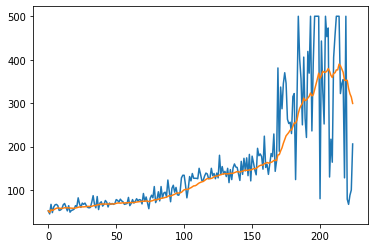

Loss: [3960.6335]


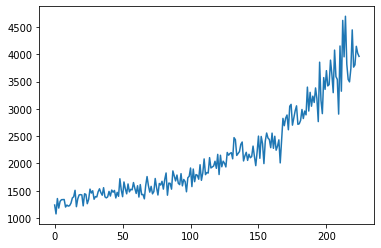

In [26]:
### Entry-point function
muzero(make_cartpole_config())